In [16]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")
# %pip install contextily

import matplotlib.colors as mcolors
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [17]:
%%time
# 4min 32s
df_shap = pd.read_csv("./output/food_localness_final_oct_new_shap_values.csv", sep=",", header=0)
df_shap = df_shap.drop(columns=['account_id','customer_lon','customer_lat','vendor_id','vendor_lon','vendor_lat'])
print(df_shap.shape[0])

df_localness = pd.read_csv('./data/food_localness_final_oct_new.csv')
print(df_localness.shape[0])

df_shap.head()

2778722
2778722
CPU times: user 39.7 s, sys: 7.29 s, total: 47 s
Wall time: 57 s


order_id  shap_customer_lon  shap_customer_lat  shap_basket_amount_lc  shap_price_per_item  shap_order_time_hour  shap_total_duration  shap_estimated_rent  shap_entropy_0.5km  shap_entropy_2km  shap_entropy_5km  shap_incentive_amount_lc  shap_incentive_delivery  shap_incentive_menu_discount  shap_incentive_voucher_wallet  shap_consistency  shap_delivery_fee_amount_lc  shap_main_cuisine  shap_total_orders  shap_rating  shap_n_rating  shap_isweekend  shap_restaurant_count_0.5km  shap_restaurant_count_0.5_1km  shap_restaurant_count_1_2km  shap_restaurant_count_2_3km  shap_restaurant_count_3_4km  shap_restaurant_count_4_5km
0  1304769890 -0.02001           -0.01686           0.00286                -0.02344             -0.00787              -0.01087             0.01402              -0.04546            -0.01858          0.00625           0.01216                   0.00848                  -0.00008                      -0.00070                       -0.00390          -0.12115                     0.02295            -0.00405           0.00059      0.00404        -0.00208        -0.03179                     -0.02338                       -0.01309                     0.01061                      0.02541                      0.00883                     
1  1304769334 -0.02371           -0.01162           0.00161                -0.02036             -0.01088              -0.00959             0.01303              -0.02078            -0.00839          0.00440           0.00838                   0.00941                  -0.00651                      -0.00084                       -0.00164          -0.12400                     0.02345            0.00293            -0.00663     -0.00158       0.00101         -0.03968                     -0.03642                       -0.01071                     0.01071                      0.02760                      0.00582                     
2  1306219965 -0.01736           -0.04002           0.00204                -0.00857             -0.00048              0.00607              0.00402              -0.04500            -0.01369          -0.00544          -0.01021                  0.00348                  -0.00786                      -0.00260                       -0.00054          0.01120                      0.03195            -0.00172           0.00124      0.01794        -0.00049        -0.06548                     -0.01417                       -0.01092                     0.00078                      0.01011                      -0.00628                    
3  1295994041 -0.01674           -0.04614           0.00445                -0.00547             -0.00390              0.03924              0.00334              -0.04449            -0.01331          -0.00697          -0.00886                  0.00316                  -0.00792                      -0.00228                       -0.00109          0.02295                      0.03069            -0.00229           -0.00155     0.02368        -0.00020        -0.06275                     -0.01473                       -0.01089                     0.00022                      0.01141                      -0.00829                    
4  1304742536 -0.00542           -0.03611           -0.00138               -0.02105             -0.02472              -0.02454             -0.01087             -0.06368            -0.02259          -0.01490          -0.04545                  -0.14190                 0.01682                       -0.00053                       0.00302           0.15575                      0.01069            -0.00318           -0.01963     -0.03092       0.00062         -0.06862                     -0.00769                       -0.00645                     -0.01258                     0.00209                      -0.01594

In [18]:
df_shap_merged = df_localness.merge(df_shap, on='order_id')
print(df_shap_merged.shape[0])

2778722


# (Optional) Quadrant plot

In [5]:
selected_feature = 'estimated_rent'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, restaurant_count_0.5km,
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet

benchmark = df_shap_merged[selected_feature].median()
df_shap_need = df_shap_merged[[selected_feature,'shap_'+selected_feature]]
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'High-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]>=benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'High-Negative'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]>0),'Quadrant'] = 'Low-Positive'
df_shap_need.loc[(df_shap_need[selected_feature]<benchmark) & (df_shap_need['shap_'+selected_feature]<=0),'Quadrant'] = 'Low-Negative'
print(df_shap_need.Quadrant.value_counts())

Low-Negative     819192
High-Negative    786456
High-Positive    605028
Low-Positive     572285
Name: Quadrant, dtype: int64


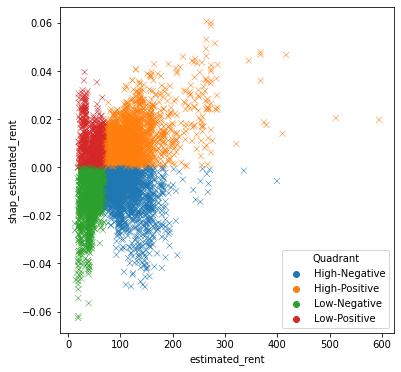

CPU times: user 2.22 s, sys: 1.33 s, total: 3.55 s
Wall time: 3.51 s


In [6]:
%%time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_shap_need.head(10000), 
                x=selected_feature, 
                y='shap_'+selected_feature, 
                hue="Quadrant", 
                marker='x')  # Use marker='x' here
plt.show()

# 1. Hexagon - best visualization for 2 million points

index                                                                                                                                         geometry
h3_polyfill                                                                                                                                                            
8843a1040dfffff  0      POLYGON ((54.98601 24.99009, 54.98778 24.98581, 54.99287 24.98470, 54.99618 24.98786, 54.99441 24.99213, 54.98933 24.99324, 54.98601 24.99009))
8843a1081bfffff  0      POLYGON ((54.91255 24.78901, 54.91432 24.78475, 54.91939 24.78364, 54.92269 24.78679, 54.92092 24.79105, 54.91585 24.79216, 54.91255 24.78901))
8843a10649fffff  0      POLYGON ((54.91739 25.04395, 54.91917 25.03967, 54.92426 25.03856, 54.92757 25.04172, 54.92579 25.04600, 54.92070 25.04711, 54.91739 25.04395))
8843a1325dfffff  0      POLYGON ((55.06282 25.12884, 55.06459 25.12456, 55.06969 25.12344, 55.07302 25.12661, 55.07124 25.13089, 55.06615 25.13201, 55.06282 25.12884))
8843acc007fffff  0      POLYGON ((55.36274 25.37147, 55.36450 25.36717, 55.36962 25.36604, 55.37298 25.36921, 55.37122 25.37352, 55.36610 25.37464, 55.36274 25.37147))

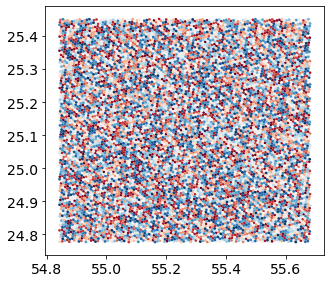

In [19]:
from shapely.geometry import box

bound_lat = [24.776468,25.451666]
bound_lon = [54.842954,55.680861] # 25.637066, 55.849584 

dubai_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# %pip install h3pandas
# create hexagon within the UAE border
import geopandas as gpd
import h3pandas

resolution = 8 # Average edge length: 500m
hexagons = dubai_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.head()

count   1351.00000
mean    77.06840  
std     54.30847  
min     19.80440  
25%     50.20303  
50%     65.66343  
75%     87.36917  
max     591.52060 
Name: estimated_rent, dtype: float64
We use feature median values: 65.66343498371154 to distinguish High and Low feature values!!!!
estimated_rent
count   1351.00000
mean    6.99931   
std     4.13312   
min     0.00000   
25%     5.10379   
50%     6.86797   
75%     8.52777   
max     58.20000  
Name: incentive_amount_lc, dtype: float64
We use feature median values: 6.867965708989805 to distinguish High and Low feature values!!!!
incentive_amount_lc
count   1351.00000
mean    0.11815   
std     0.17177   
min     0.00000   
25%     0.00000   
50%     0.00949   
75%     0.19484   
max     0.69798   
Name: entropy_0.5km, dtype: float64
We use feature median values: 0.009486383592197457 to distinguish High and Low feature values!!!!
entropy_0.5km
count   1351.00000
mean    0.43462   
std     0.22938   
min     0.00000   
25%     0.27757 

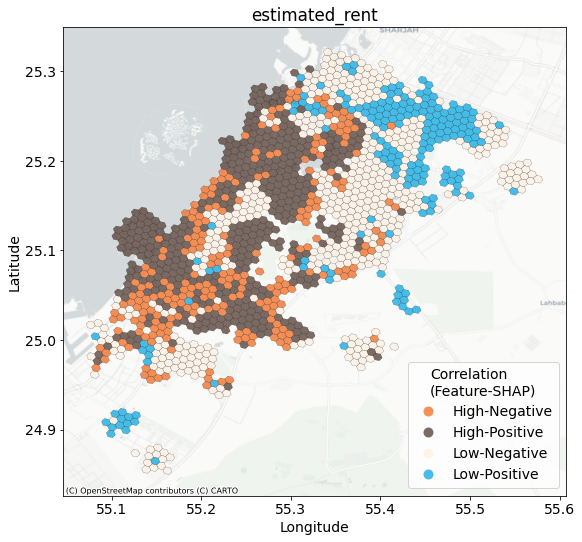

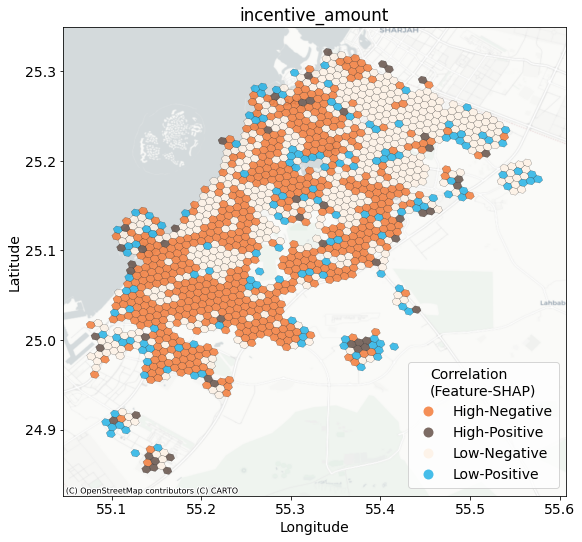

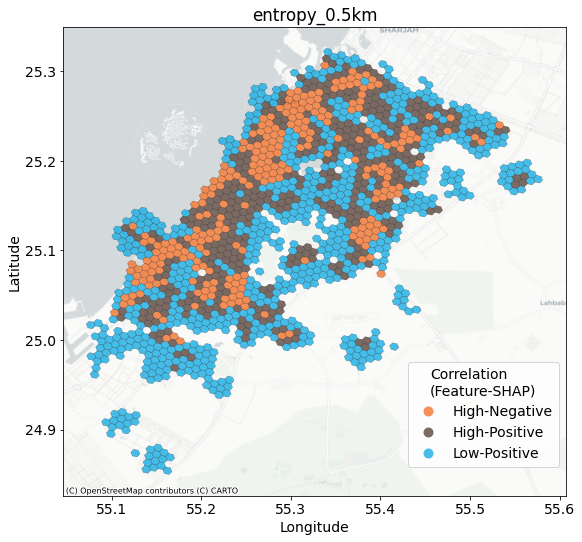

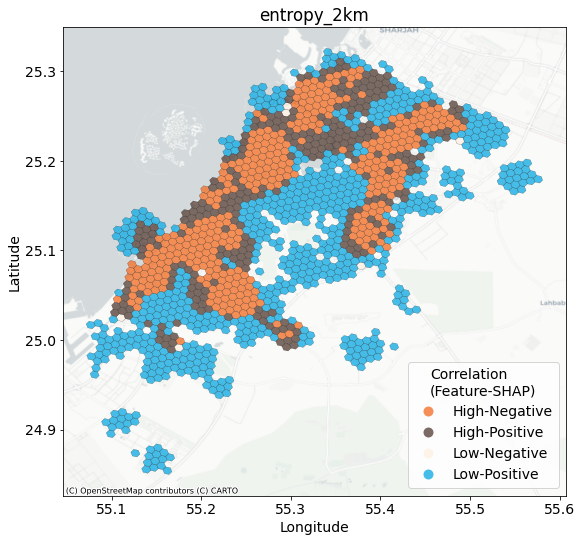

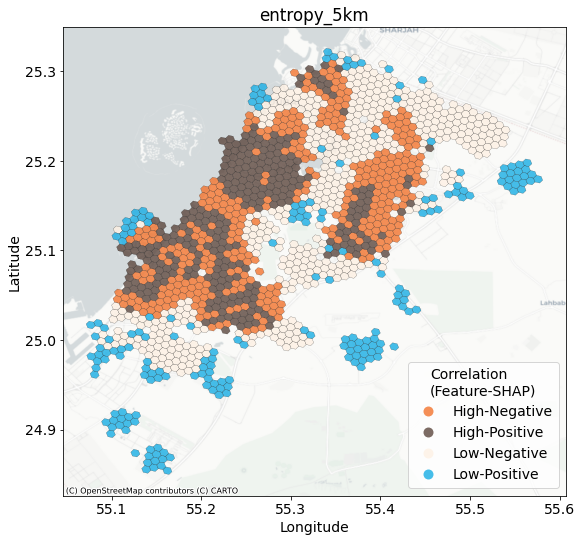

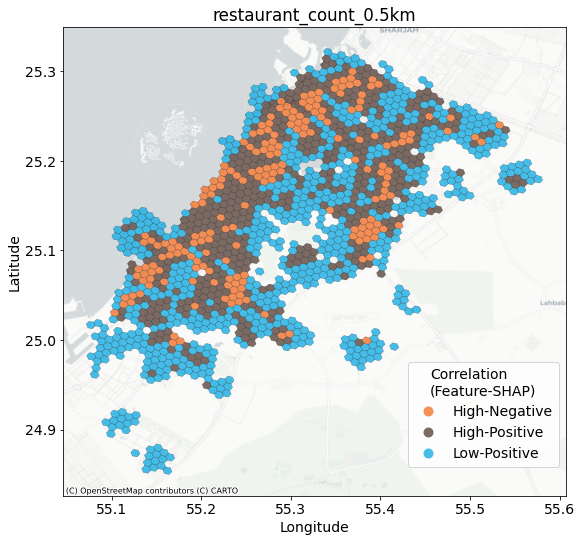

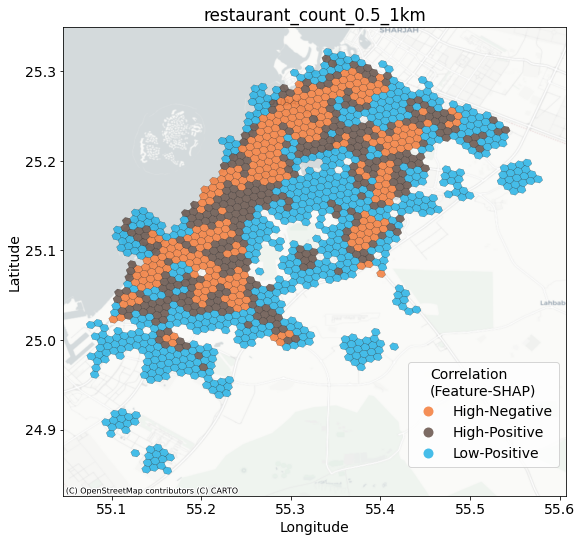

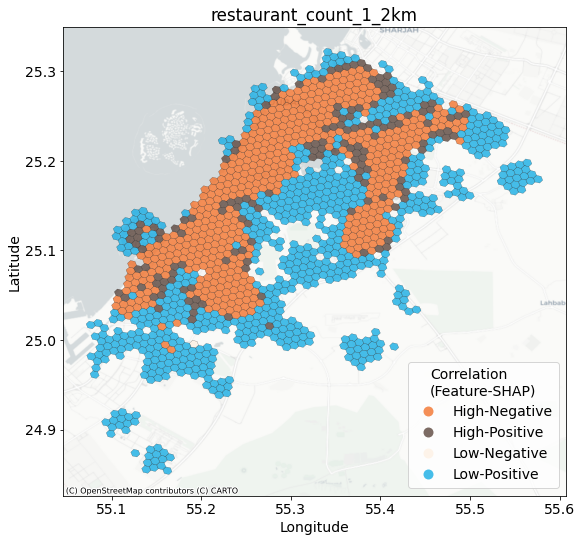

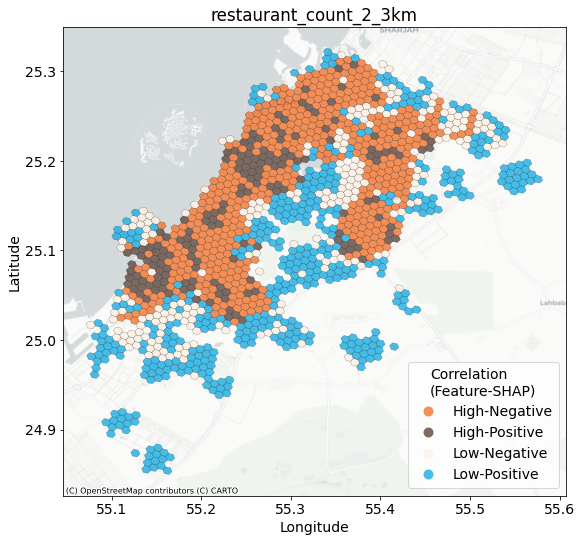

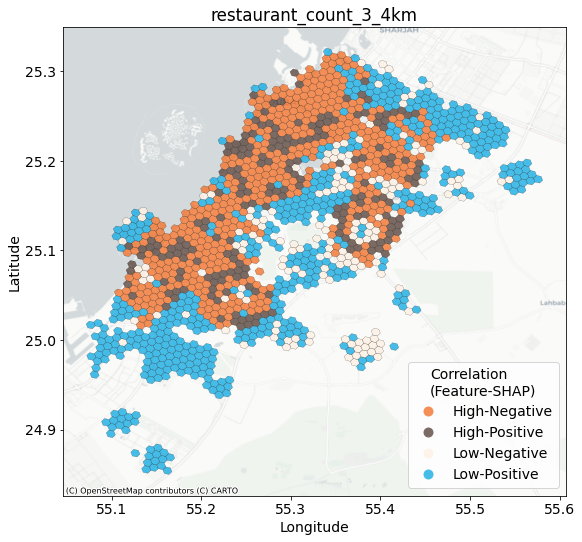

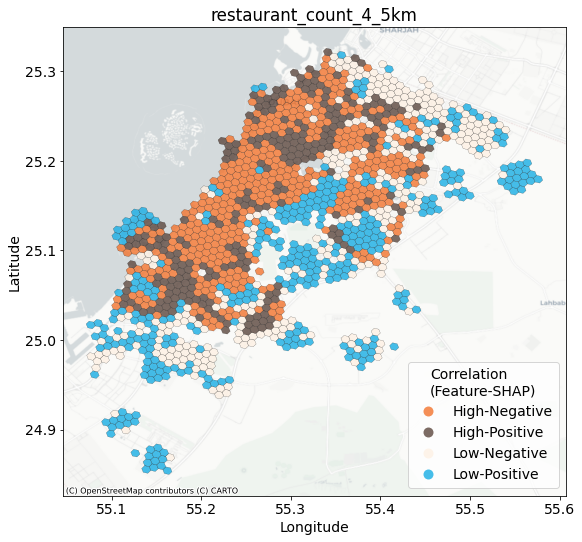

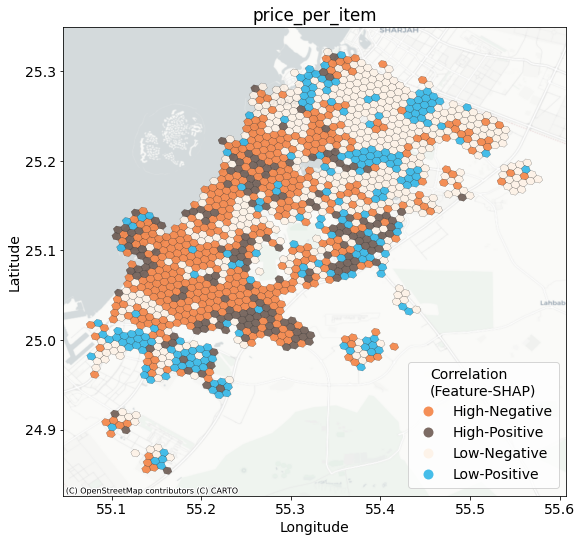

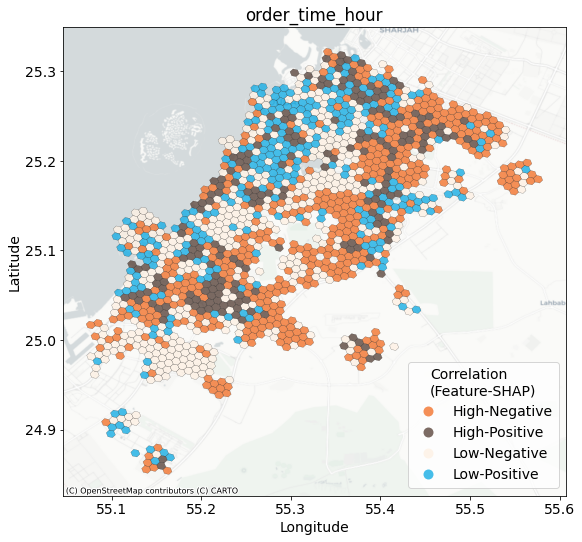

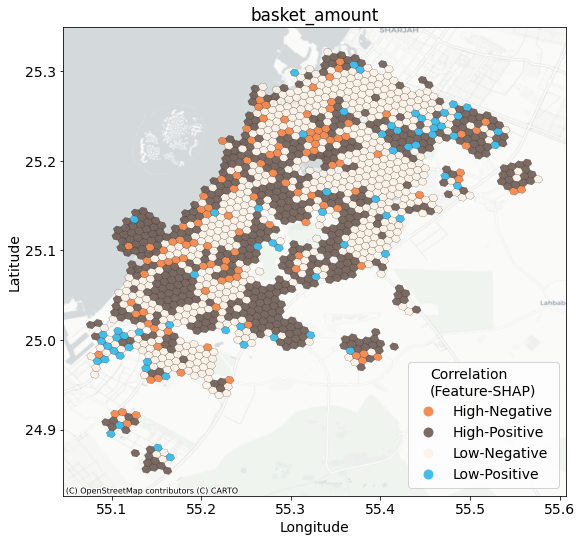

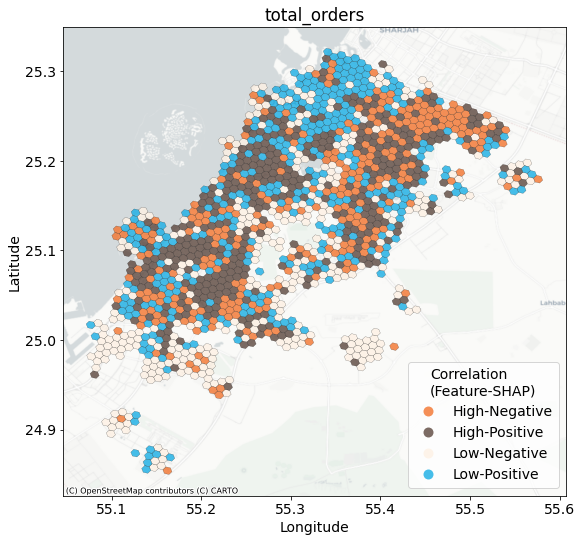

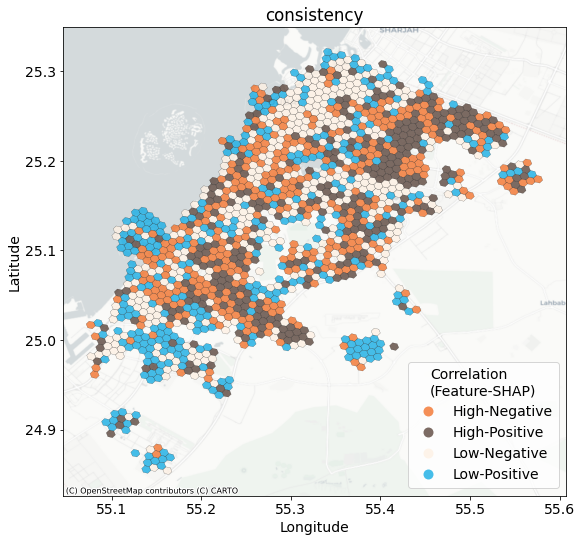

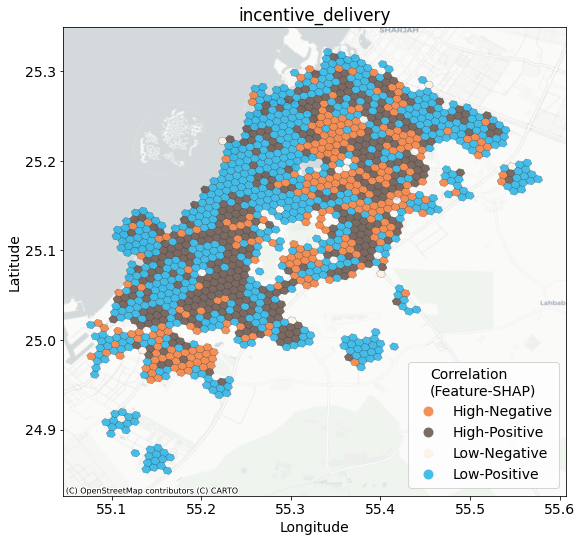

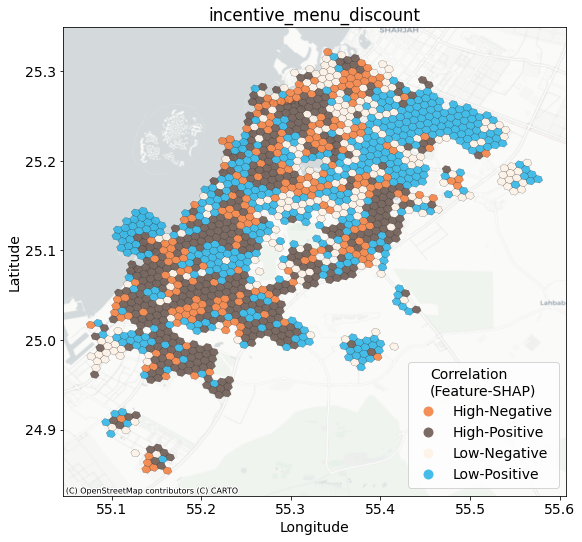

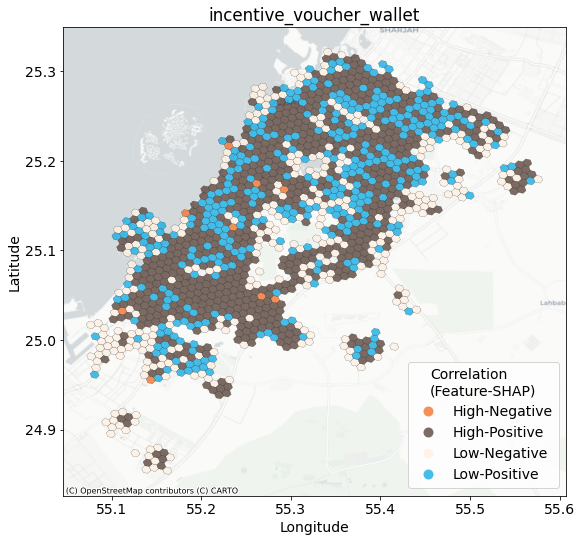

In [69]:
%%time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import contextily as cx

# selected_feature = 'incentive_delivery'
# Some continuous features to be considered: 
# For 'estimated_rent', please refer to 07_spatial_SHAP_rent.ipynb, because we want to use first and fourth quartiles of estimated rent to distinguish between low and high rents
all_con_features = ['incentive_amount_lc', 'entropy_0.5km', 'entropy_2km', 'entropy_5km', 'restaurant_count_0.5km', 'restaurant_count_0.5_1km', 
                    'restaurant_count_1_2km', 'restaurant_count_2_3km', 'restaurant_count_3_4km', 'restaurant_count_4_5km', 'price_per_item', 'order_time_hour', 
                    'basket_amount_lc', 'total_orders', 'consistency', 'incentive_delivery', 'incentive_menu_discount', 'incentive_voucher_wallet']

for selected_feature in all_con_features:
    print(selected_feature)
    
    df_onefeature = df_shap_merged[['account_id','order_id','customer_lon','customer_lat', selected_feature,'shap_'+selected_feature]]
    # df_onefeature = df_onefeature[df_onefeature['incentive_amount_lc']<=10]
    geometry2 = [Point(xy) for xy in zip(df_onefeature.customer_lon, df_onefeature.customer_lat)]
    gdf_onefeature = GeoDataFrame(df_onefeature, crs="EPSG:4326", geometry=geometry2)

    mean_hex = gpd.sjoin(gdf_onefeature, hexagons, op='within') 
    hexagon_agg = mean_hex[['index_right',selected_feature,'shap_'+selected_feature]].groupby('index_right').agg('mean')
    hexagon_agg_ordernumber = hexagons.merge(hexagon_agg,left_index=True,right_index=True) # focus on hexagons that contains delivery data
    # print(hexagon_agg_ordernumber.shape[0])
    # hexagon_agg_ordernumber.head() # hexagon_agg_ordernumber[selected_feature].hist() # df_shap_merged[selected_feature].median()
    # print(hexagon_agg_ordernumber[selected_feature].describe())
    
    benchmark = hexagon_agg_ordernumber[selected_feature].median()
    print('We use feature median values:',benchmark,'to distinguish High and Low feature values!!!!')
    shap_threshold = 0.00
    
    hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'High-Positive'
    hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'High-Negative'
    hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'Low-Positive'
    hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<benchmark) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'Low-Negative'
    # print(hexagon_agg_ordernumber.Quadrant.value_counts())
    # hexagon_agg_ordernumber.head(2)

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(1, figsize=(9, 9))
    
    quadrant_categories = ['High-Negative', 'High-Positive', 'Low-Negative', 'Low-Positive']
    colorlist = ['#f3742e','#5c473e', '#fef1e4','#18aee5']  # Ensure enough colors for unique categories
    color_map = dict(zip(quadrant_categories, colorlist))  # Map categories to colors
    cmap = mcolors.ListedColormap([color_map[q] for q in sorted(hexagon_agg_ordernumber['Quadrant'].unique().tolist())])
    # cmap = mcolors.ListedColormap(colorlist)
    
    hexagon_agg_ordernumber.plot(
        column='Quadrant',         # Categorical column
        cmap=cmap,               # Colormap for categories
        alpha=0.8,
        legend=True,               # Show legend for categories
        categorical=True,          # Specify that the column is categorical
    #     markersize= gdf_onefeature[selected_feature]/5,
        edgecolor = 'black',
        linewidth=0.2,
        ax=ax
    )
    
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1,0.3))
    leg.set_title('Correlation\n(Feature-SHAP)')
    cx.add_basemap(ax, crs=gdf_onefeature.crs, source=cx.providers.CartoDB.Positron)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if '_lc' in selected_feature:
        title1 = selected_feature.replace('_lc','')
    else: 
        title1 = selected_feature
    plt.title(title1)
    plt.savefig('./output/hex_spatial_SHAP_'+selected_feature+'.png', dpi=300, bbox_inches='tight')
    # plt.show()

In [56]:
# hexagon_agg_ordernumber.explore(
#     column='Quadrant',
#     cmap=cmap,
# )

# (optional) 2. Second visualization solution: Interactive map

In [5]:
# select a sample to speed up
df_shap_merged_test = df_shap_merged.head(10000)
df_shap_merged_test = df_shap_merged_test[['order_id','customer_lon','customer_lat','estimated_rent','shap_estimated_rent']]

#Converting Pandas DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_shap_merged_test.customer_lon, df_shap_merged_test.customer_lat)]
gdf = GeoDataFrame(df_shap_merged_test, crs="EPSG:4326", geometry=geometry)

In [6]:
benchmark = gdf['estimated_rent'].median()
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'High-Positive'
gdf.loc[(gdf['estimated_rent']>=benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'High-Negative'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'Low-Positive'
gdf.loc[(gdf['estimated_rent']<benchmark) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'Low-Negative'
gdf.Quadrant.value_counts()

Low-Negative     4410
High-Positive    2883
Low-Positive     1667
High-Negative    1040
Name: Quadrant, dtype: int64

In [8]:
%%time

# Low & Negative: Something muted, like light gray (to indicate low values and negative impact).
# Low & Positive: Light blue (to show low values but positive impact).
# High & Negative: Orange (to indicate high values with negative impact).
# High & Positive: Green (to highlight the best combination—high values and positive impact).
# cmap = mcolors.ListedColormap(['Orange', 'Green', 'lightgray', 'lightblue'])

# High-Negative, High-Positive, Low-Negative, Low-Positive
color2 = ['#f3742e','#5c473e', '#fef2e5','#18aee5']

gdf.head(1000).explore(
    column='Quadrant',  # make choropleth based on "BoroName" column
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles #OpenStreetMap
    cmap=color2,
    style_kwds=dict(color="gray",weight='0.1',fillOpacity=0.6, style_function=lambda x: {"radius":x["properties"]["estimated_rent"]/50})
)

CPU times: user 142 ms, sys: 3.4 ms, total: 145 ms
Wall time: 611 ms
